# End to End Machine Learning Project/Revision Guide

## Load and Visualise Data

In [96]:
import os
import tarfile
import urllib
import numpy as np

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

In [97]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

df = load_housing_data()
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


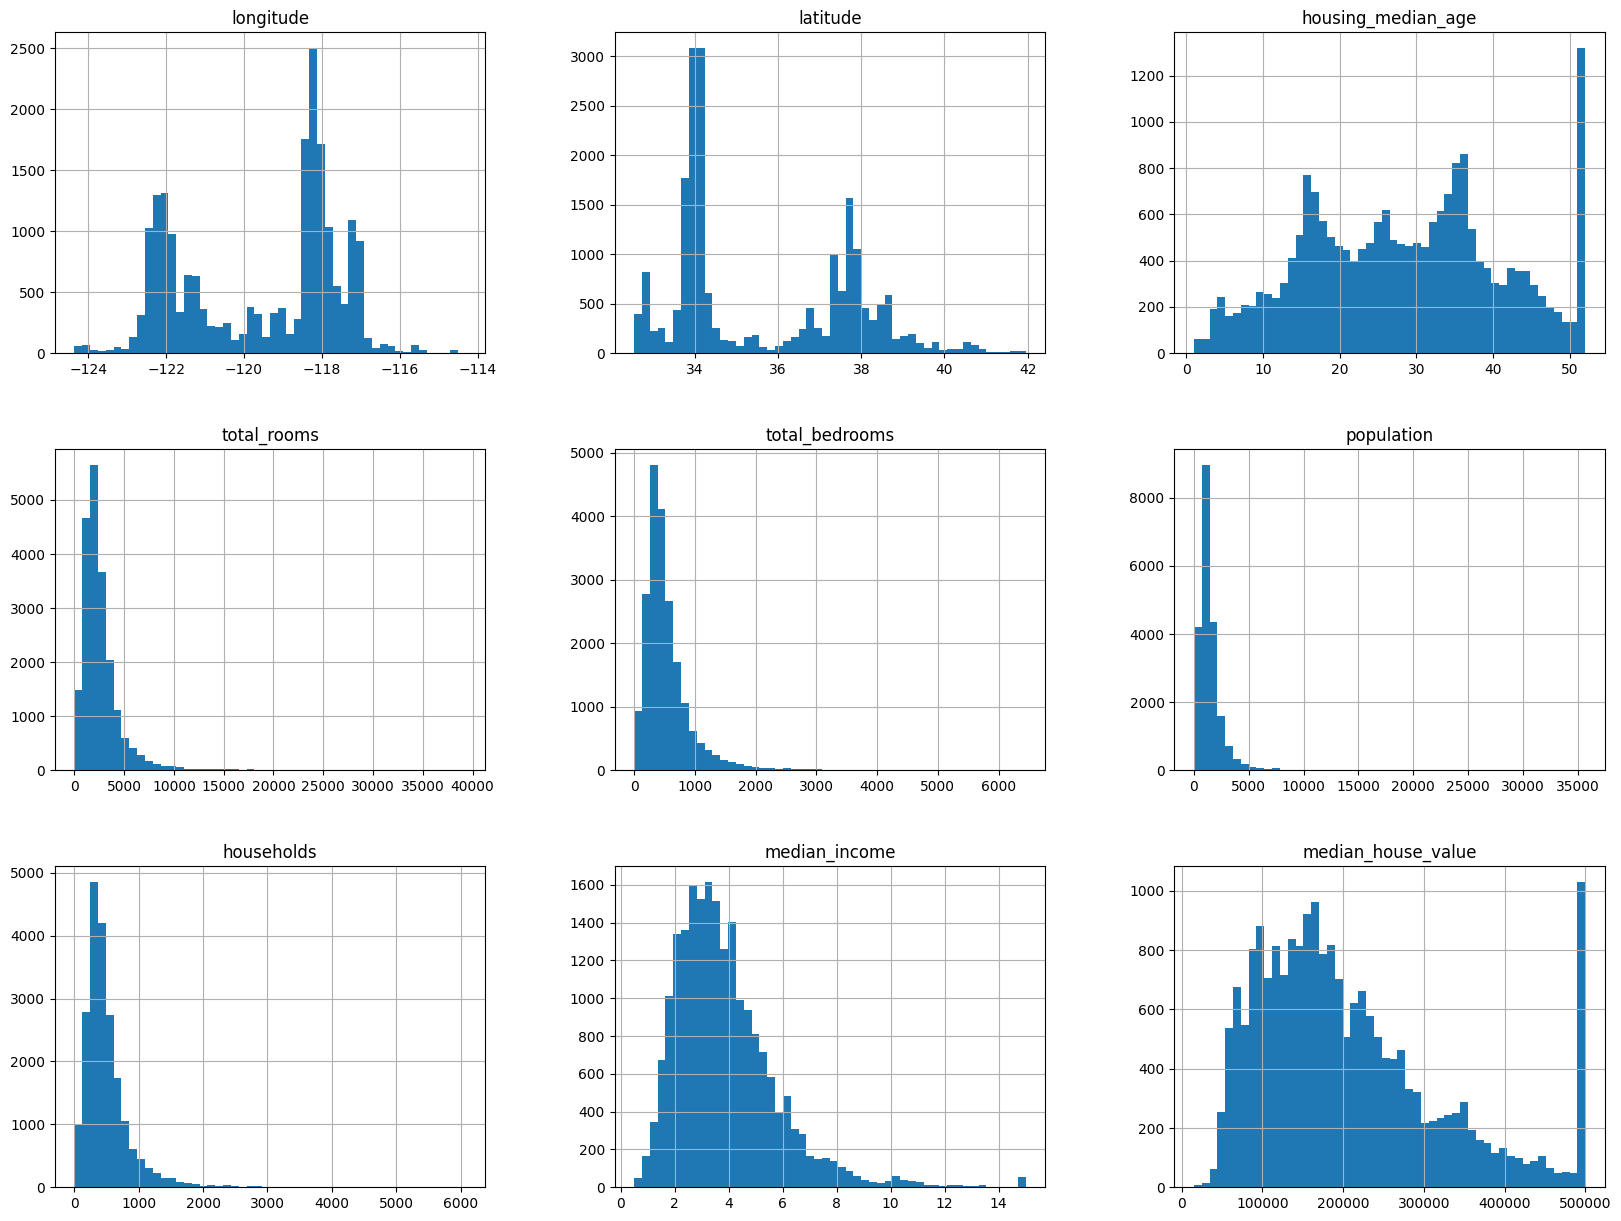

In [99]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(20,15))
plt.show()


In [100]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)


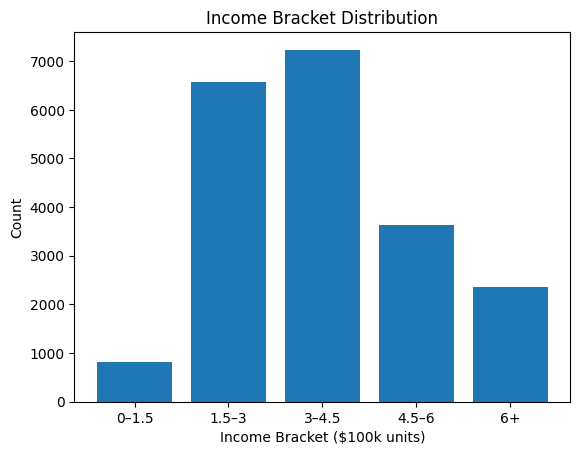

income_cat
(0.0, 1.5]     822
(1.5, 3.0]    6581
(3.0, 4.5]    7236
(4.5, 6.0]    3639
(6.0, inf]    2362
Name: count, dtype: int64


In [101]:
df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf])
counts = df["income_cat"].value_counts().sort_index()

labels = ["0–1.5", "1.5–3", "3–4.5", "4.5–6", "6+"]

plt.bar(range(len(counts)), counts)
plt.xticks(range(len(counts)), labels)
plt.xlabel("Income Bracket ($100k units)")
plt.ylabel("Count")
plt.title("Income Bracket Distribution")
plt.show()

print(counts)

## Split Data into Train/Test

In [102]:
from sklearn.model_selection import StratifiedShuffleSplit
splt = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)      # split(x, y) -> x: dataset your wanna split, y: the labels you wanna stratify by
for train_index, test_index in splt.split(df, df["income_cat"]):               # the loop returns 2 arrays of indices for train and test sets
    strat_test_set = df.loc[test_index]
    strat_train_set = df.loc[train_index]


for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)                              # drop the income_cat attribute so the data is back to its original state
                                                                               # example of polymorphism - split method works differently for different objects


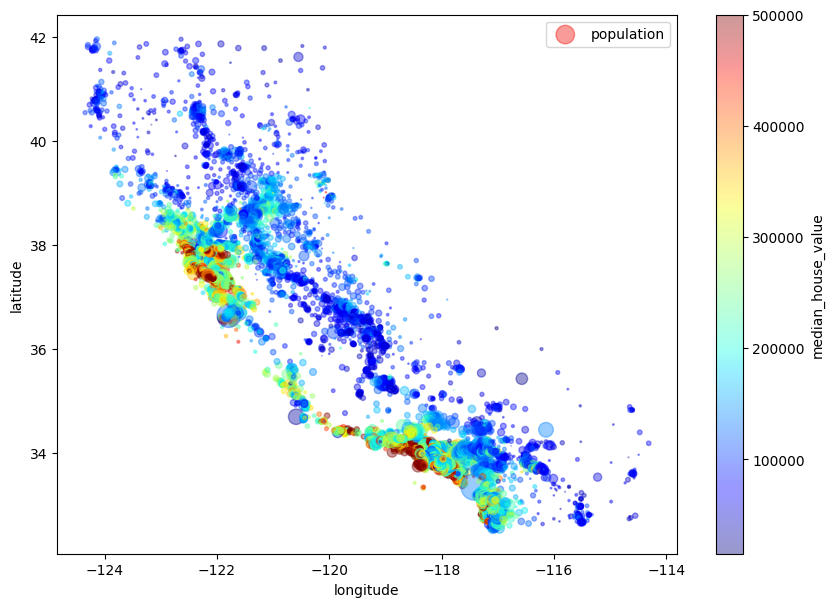

In [103]:

df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=df["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True
)
plt.legend()


In [104]:
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"] = df["population"]/df["households"]

corr_matrix = df.drop(columns=["ocean_proximity", "income_cat"]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)  


median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [105]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [106]:
df.drop(columns=["income_cat"], axis=1, inplace=True)
df.isna().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms              207
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity               0
rooms_per_household           0
bedrooms_per_room           207
population_per_household      0
dtype: int64

## Preprocessing


In [107]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")                    # fills each column's missing values with the median of that column (creates the tool, doesn't apply it yet)
housing_num = housing.drop(columns=["ocean_proximity"])       # create a new dataframe housing_num by dropping the text attribute ocean_proximity
imputer.fit(housing_num)                                      # applies it
X = imputer.transform(housing_num)                            # transforms the data and returns a numpy array
housing_tr = pd.DataFrame(X, columns=housing_num.columns, 
                          index=housing_num.index)            # convert the numpy array back to a pandas dataframe
housing_tr.isna().sum()                                       # check that there are no missing values anymore


longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

### Handling Text and Categorical Attributes

In [108]:
df['ocean_proximity'].value_counts()               # attribute is categorical - we must use an encoding technique to convert it to numbers

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [109]:
ocean_proximity = housing[['ocean_proximity']]
ocean_proximity.tail()

,ocean_proximity
15174,<1H OCEAN
12661,INLAND
19263,<1H OCEAN
19140,<1H OCEAN
19773,INLAND


### Use OrdinalEncoder if there is real order to the categories (e.g Bachelors < Masters < phd)

BEWARE: ML models will treat ordinal numbers as distances, i.e., NEAR OCEAN (3) is "closer" to <1H OCEAN (4) than to NEAR BAY (2) which is nonsense


In [110]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
ocean_proximity_encoded = ordinal_encoder.fit_transform(ocean_proximity)
ocean_proximity_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [111]:
ordinal_encoder.categories_                     # gives the list of categories and their order (0 indexed)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Use OneHotEncoder when there's no order - so here OneHotEncoder is best

If performance is slow due to large dataset, you may want to replace the categorical input with useful numerical features related to the categories: e.g., change `ocean_proximity` to perhaps a figure representing the distance from the ocean.



In [112]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
ocean_proximity_onehot = onehot_encoder.fit_transform(ocean_proximity)         # runs fit and tramsform together
ocean_proximity_onehot.toarray()[:10]

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [113]:
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

If an object has `fit()` and `transform()` → scikit-learn will treat it as a transformer. They all follow this shape:

class Transformer:
    def fit(self, X, y=None):
        # learn something from X
        return self

    def transform(self, X):
        # apply the learned thing to X
        return new_X


In [114]:
from sklearn.base import BaseEstimator, TransformerMixin       
import numpy as np                  

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)    


### Walkthrough of the code above

### The imports and column indices
- `BaseEstimator` and `TransformerMixin` are helper classes that give you nice extras like `get_params` , `set_params` , and `fit_transform` 
- the `*_ix` variables are just the column indices of each attribute in X. So later, `X[:, rooms_ix]` means “take the rooms column from X”.

### Defining the transformer class
- `class CombinedAttributesAdder(BaseEstimator, TransformerMixin):` creates a class that inherits both `BaseEstimator` and `TransformerMixin`
- Scikit-learn's rule is: "if an object has `fit` and `transform` methods, I'll treat it as a transformer"

### `__init__`: setting a hyperparameter
- `__init__` runs when you create the object, i.e. when you create `attr_adder`
- `add_bedrooms_per_room` is a hyperparameter - it ocntrols whether we add the `bedrooms_per_room` feature or not
- storing it in `self.add_bedrooms_per_room` means you can access it later in `transform` and SKL can automatically read it and set it (for hyperparameter search)

### `fit`: here nothing happens
- Some transformers need to learn something from the data in `fit` (e.g. StandardScaler learns the mean and std)
- But here, it's just row-by-row maths so `fit` just returns `self` to comply with SKL's API - you still need `fit` so it can fit into `Pipeline`

### `transform`: where the real work happens
- the new `rooms_per_household` and `population_per_household` are created via element-wise division
- `bedrooms_per_room` attribute is optional - only carry out if hyperparameter says so
- `return np.c_*` takes the newly created arrays and sticks them side-by-side as new columns in X
- Before: `X` was `(n_samples, old_features)` 
- After: `(n_samples, old_features + 2)` (or +3 if you add `bedrooms_per_room`).

### Using the transformer
- `attr_adder` is an instance of your transformer. `df.values` is the NumPy array of the housing data, and `transform` returns the new array, now with the extra engineered features



### Feature Scaling 
Feature scaling makes all numerical features have comparable scales so that ML algorithms don’t get confused by huge differences between feature magnitudes. For example, `total_rooms` ranges from 6 → 39,320 whereas, whereaas `median_income` ranges from 0 → 15. Without scaling, a model sees rooms as thousands of times bigger than income, even though rooms are not more important than median income, which the model would imply.

- **min-max scaling** - xscaled ​= x - xmin / xmax​ − xmin​ (Normalisation)
- Use `MinMaxScaler()` 
- BEWARE: outliers can ruin results

- **standardisation** - xscaled ​= x − μ / σ​ (Z-score)
- Use `StandardScaler()`
- This is normally the best option as it is most consistent and handles outliers

### Pipelines and ColumnTransformers

### Transformation Pipelines
- Creates a sequence of transformations for **numerical columns**
- The Pipeline constructor takes a list of **name/estimator** pairs defining a sequence of steps:
- **raw data ──► Step 1 ──► Step 2 ──► Step 3 ──► final transformed data**
- When you do `.fit_transform()` on a pipeline, it calls `fit()` on all the estimators, then `transform()` is applied in order
- The final result is a clean, scaled NumPy array ready for ML

**NOTE:** All but the last estimator must be transformers (i.e., they must have a `fit_transform()` method)

In [115]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

### ColumnTransformer
- Pipelines work well for **numerical columns** only. Real datasets have **categorical columns, dates, text, etc**
- We need a way to say: "Use the num_pipeline for numeric columns and OneHotEncoder for categorical columns and combine the results"
- This is what ColumnTransformer does

- Below, `num_pipeline` is applied to all numerical attributes and then `OneHotEncoder` to `ocean_proximity` (the categorical variable)
- `ColumnTransformer` handles sending the right columns to the right transformers and then combining all outputs into one big matrix
- You could also use "drop" and/or "passthrough" to drop/keep columns respectively, like so:

("num", num_pipeline, num_cols),
("cat", OneHotEncoder(), cat_cols),
("keep", "passthrough", keep_cols)

**NOTE:** OneHotEncoder outputs a **sparse matrix** (most values are 0). The numerical pipeline produces a **dense matrix**. ColumnTransformer detects the mix and returns:

- Sparse matrix if sparse_output_density < threshold
- Dense otherwise

By default, if < 30% of values are non-zero, return sparse. In this example enough values are non-zero that it returns a dense matrix.



In [116]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

## Select and train a model

1) Initialise the model - create the model object and choose hyperparameters - e.g:

lin_reg = LinearRegression()
svm_clf = SVC(kernel="rbf", C=2)
tree = DecisionTreeRegressor(max_depth=5)
rf = RandomForestClassifier(n_estimators=200)

2) `.fit()` - this is where the model actually learns patterns. After this the model stores learned parameters internally - e.g. LinearRegression → `coef_`, `intercept_`

3) `.predict()` - this is where the model is used on the new data - e.g:

lin_reg.predict(X_test)
svm_clf.predict(X_test)
rf.predict(X_test)

### Pipelines also follow this pattern 

pipeline = Pipeline([
    ("preprocess", some_transformer),
    ("model", LinearRegression())
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)


In [117]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [118]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [119]:
print("Labels:", list(some_labels))


Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [120]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

# Preiction error is $68,000 which is very high for this problem

68627.87390018745


In [121]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse) 
print(tree_rmse)

# now the prediction error is 0 which means the model has overfitted the training data

0.0


### Better Evaluation Using Cross-Validation

- Good to use Scikit-Learn’s *K-fold cross-validation* feature
- It splits the training set into k distinct subsets called *folds* and tries to evaluate the model k times, picking a different fold for evaluation every time and training on the other 9 folds
- Result is an array containing the 10 evaluation scores

### `cross_val_score`
- **BEWARE:** it expects a utility function (greater is better), rather than a cost function (lower is better), so if the true MSE was 50,000 , sklearn would return -50,000 - MSE is a cost/loss function.

In [122]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

# now the decision tree model looks much less impressive

Scores: [73467.90138516 72093.9357309  68158.88804335 73277.54109792
 70018.43268026 78486.4076505  70953.53641407 74118.03576867
 67277.20007243 70469.98300913]
Mean: 71832.18618523731
Standard deviation: 3074.0078384357766


In [123]:
# let's try the linear regression model with cross-validation

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

# the results show that the linear regression model is slightly better than the decision tree model on this dataset
# shown by the lower mean RMSE and lower standard deviation 

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180584


In [124]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

# the random forest model seems to be the best so far
# however it is still overfitting the training set a bit as the training RMSE is much lower than the cross-validation RMSE


18630.274079438448
Scores: [51363.14621588 49024.38018972 46471.91356912 51825.47358501
 47334.5468007  51615.81594772 51975.69305041 49550.4023722
 48840.5351783  53704.78537904]
Mean: 50170.669228810606
Standard deviation: 2172.309043510818


### (How to save your models for easy comparisons between models in the future)

In [125]:
import joblib
joblib.dump(forest_reg, "forest_reg_model.pkl")
# and later you can load it like this:
forest_reg_loaded = joblib.load("forest_reg_model.pkl")

## Fine-Tuning Your Model

1) `GridSearchCV` - you tell it which hyperparameters you would like it to experiment with and what values to try out, and it uses cross-validation to evaluate all the possible combinations of hyperparameter values. BRUTE-FORCE

2) Randomized Search - an alternative to GridSearchCV for hyperparameter tuning. It intelligently samples random combinations of hyperparameters instead of trying every possible combination.

3) Ensemble Methods - ensemble methods combine multiple models to produce a stronger, more accurate model.

### GridSearchCV Method

#### `param_grid` 
It is a list of dictionaries. Each dict = a 'search block'. Each block tells `GridSearchCV`: "try every possible combination of these parameters". In the example below, block1 has 3 values for `'n_estimators'` and 4 values for `'max_features'` which = 12 combinations. Applying this same logic, block2 has 6 combinations. Therefore, there's a total of 18 combinations and each model is trained 5 times (`cv=5`) meaning there's a total of 90 model trianings.

#### GridSearchCV constructor
grid_search = GridSearchCV(
    forest_reg,                          # Base model to optimise
    param_grid,                          # Hyperparameter grid to search over
    cv=5,                                # Number of cross-validation folds
    scoring='neg_mean_squared_error',    # Evaluation metric
    return_train_score=True              # Store train scores too
)

#### `fit()` handles the rest

In [126]:

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

,estimator,RandomForestRegressor()
,param_grid,"[{'max_features': [2, 4, ...], 'n_estimators': [3, 10, ...]}, {'bootstrap': [False], 'max_features': [2, 3, ...], 'n_estimators': [3, 10]}]"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,30


In [127]:
grid_search.best_params_     # returns best combination of parameters found

{'max_features': 6, 'n_estimators': 30}

In [128]:
grid_search.best_estimator_  # returns the model which uses the best parameters

,n_estimators,30
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,6
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [129]:
cvresults = grid_search.cv_results_
for mean_score, params in zip(cvresults["mean_test_score"], cvresults["params"]):
    print(np.sqrt(-mean_score), params)


63611.378935664114 {'max_features': 2, 'n_estimators': 3}
55287.030861062536 {'max_features': 2, 'n_estimators': 10}
52669.023403895495 {'max_features': 2, 'n_estimators': 30}
60743.796301293514 {'max_features': 4, 'n_estimators': 3}
52952.64379546712 {'max_features': 4, 'n_estimators': 10}
50286.83597115971 {'max_features': 4, 'n_estimators': 30}
59871.34988041569 {'max_features': 6, 'n_estimators': 3}
52020.990671227264 {'max_features': 6, 'n_estimators': 10}
49929.936888974844 {'max_features': 6, 'n_estimators': 30}
58651.215447529714 {'max_features': 8, 'n_estimators': 3}
52264.47980320734 {'max_features': 8, 'n_estimators': 10}
50325.40019207186 {'max_features': 8, 'n_estimators': 30}
61531.02585993966 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54346.06234945424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59583.97212841746 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52363.98538701102 {'bootstrap': False, 'max_features': 3, 'n_estimato

### Displaying feature importances

Once you know which features are not useful you may want to drop some of them. Also good to look at specific errors the system makes and fix them (e.g. add extra features, getting rid of uninformative ones, cleaning up outliers, etc)

In [130]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.57761700e-02, 6.95949480e-02, 4.08133338e-02, 1.86701889e-02,
       1.72733938e-02, 1.78849876e-02, 1.66000740e-02, 3.33669445e-01,
       5.73017310e-02, 1.03789331e-01, 7.65437561e-02, 8.48833154e-03,
       1.57586194e-01, 1.14614690e-04, 2.78688867e-03, 3.10661191e-03])

In [131]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.33366944452096864), 'median_income'),
 (np.float64(0.15758619437998836), 'INLAND'),
 (np.float64(0.1037893310779765), 'pop_per_hhold'),
 (np.float64(0.07654375613670546), 'bedrooms_per_room'),
 (np.float64(0.07577616995452761), 'longitude'),
 (np.float64(0.0695949480163947), 'latitude'),
 (np.float64(0.05730173104067162), 'rooms_per_hhold'),
 (np.float64(0.04081333375029318), 'housing_median_age'),
 (np.float64(0.018670188903415104), 'total_rooms'),
 (np.float64(0.017884987601091345), 'population'),
 (np.float64(0.01727339382974397), 'total_bedrooms'),
 (np.float64(0.016600073977773005), 'households'),
 (np.float64(0.008488331537585457), '<1H OCEAN'),
 (np.float64(0.0031066119136466913), 'NEAR OCEAN'),
 (np.float64(0.00278688866971465), 'NEAR BAY'),
 (np.float64(0.00011461468950367549), 'ISLAND')]

## Evaluate Model on Test Set

Make sure when you do not do `.fit_transform()`. You MUST use `.transform()` to simulate new, unseen, real-world data. Test set must only be transformed using what was learned from the training set.

In [132]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

47590.723095102505
